### GOAL
Explore residual blocks in a classification network

In [56]:
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.functional as F

from torchvision import transforms
import torchvision.utils as vutils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

import sys
sys.path.append("../../datasets")
from pokedata import PokemonDataset

In [57]:
### Convert indices to types
csv_path = "../../data/data.csv"
df = pd.read_csv(csv_path)

type_cols = [col for col in df.columns if "type" in col]
df[type_cols[1]] = df[type_cols[1]].fillna("None") # clean up secondary type column
primary_types = df[type_cols[0]].unique()
secondary_types = df[type_cols[1]].unique()

ohe_df = pd.get_dummies(df, columns=type_cols)
ohe_df["type_1_None"] = 0   # No primary types are none, add dummy column to same sized OHE vectors
primary_cols = sorted([col for col in ohe_df.columns if type_cols[0] in col])
secondary_cols = sorted([col for col in ohe_df.columns if type_cols[1] in col])
ordered_types = sorted(secondary_types)

ind_to_type = { i:t for i,t in enumerate(ordered_types) }
ind_to_type


{0: 'None',
 1: 'bug',
 2: 'dark',
 3: 'dragon',
 4: 'electric',
 5: 'fairy',
 6: 'fighting',
 7: 'fire',
 8: 'flying',
 9: 'ghost',
 10: 'grass',
 11: 'ground',
 12: 'ice',
 13: 'normal',
 14: 'poison',
 15: 'psychic',
 16: 'rock',
 17: 'steel',
 18: 'water'}

In [58]:
# hyper parameters

# input
im_size = 96
nc = 3
# output
n_types = 19 # total pokemon types + "None"
batch_size = 128
dropout = 0.2

eval_iters = 8 # 8 is max allowed with dataset size of 5k and 4-1 train-val split
max_epochs = 100
eval_interval = 5

nf = 16
lr = 0.0002

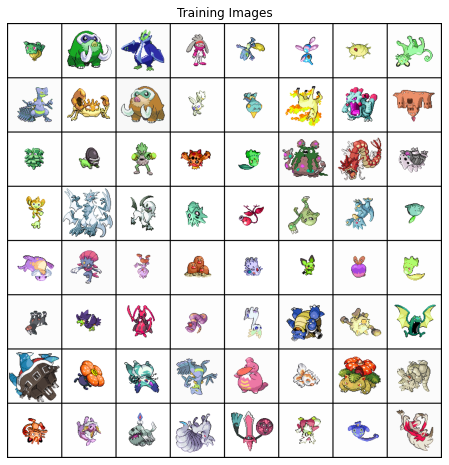

In [87]:
data_path = "../../data"
csv_path = data_path + "/data.csv"

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.ColorJitter(# brightness=0.1, 
                                                       hue=0.2, 
                                                       contrast=0.15, saturation=0.15),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

# load data
dataset = PokemonDataset(csv_file=csv_path, root_dir=data_path, transform=transform, get_types=True)

# train test split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset=dataset, lengths=[train_size, val_size])

# create dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, 
                          shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, 
                          shuffle=True)

# pick data device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(train_loader)) 
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

plt.show()

In [88]:
# Components for residual Network
class ResConvBlock(nn.Module):
    """A pre-norm resnet-like block"""
    def __init__(self, out_channels, in_channels=None, stride=1, reduce=False):
        super(ResConvBlock, self).__init__()

        self.reduce = reduce # used to bypass pooling for image reduction

        in_channels = out_channels if in_channels is None else in_channels

        self.proj_in = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels//4, 1, 1, 0, bias=False),
        )

        self.conv = nn.Sequential(
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels//4, out_channels//4, 3, stride, 1, bias=False),
        )

        self.proj_out = nn.Sequential(
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels//4, out_channels, 1, 1, 0, bias=False)
        )

        if reduce:
            # use NN to shrink x down to sum with output
            self.shrink = nn.Conv2d(in_channels, out_channels, 1, 2, 0, bias=False)

    def forward(self, x):
        x_proj = self.proj_in(x)
        x_proj = self.conv(x_proj)
        x_proj = self.proj_out(x_proj)
        if self.reduce:
            # shrink x w/ convolution
            x = self.shrink(x)
        logits = x + x_proj
        return logits


In [89]:
# in_channels = 64
# im = 96
# b_size = 16

# test_in = torch.randn((b_size, in_channels, im_size, im_size))
# print(test_in.shape)

# block_test = ResConvBlock(out_channels=128, in_channels=in_channels, stride=2, reduce=True)

# out = block_test(test_in)
# print(out.shape)

In [90]:
class SmallResNet(nn.Module):
    def __init__(self):
        super(SmallResNet, self).__init__()

        self.net = nn.Sequential(
            # input: (B, nc, 96, 96)
            nn.Conv2d(nc, nf, 1, 1, 0, bias=False), # project into filter space
            # state: (B, nf, 96, 96)
            ResConvBlock(nf),
            ResConvBlock(nf),
            ResConvBlock(nf*2, in_channels=nf, stride=2, reduce=True),
            # (B, nf*2, 48, 48)
            ResConvBlock(nf*2),
            ResConvBlock(nf*2),
            ResConvBlock(nf*4, in_channels=nf*2, stride=2, reduce=True),
            # (B, nf*4, 24, 24)
            ResConvBlock(nf*4),
            ResConvBlock(nf*4),
            ResConvBlock(nf*8, in_channels=nf*4, stride=2, reduce=True),
            # (B, nf*8, 12, 12)
            ResConvBlock(nf*8),
            ResConvBlock(nf*8),
            ResConvBlock(nf*16, in_channels=nf*8, stride=2, reduce=True),
            # (B, nf*16, 6, 6)
            nn.Flatten()
        )

        self.class_head = nn.Sequential(
            nn.Linear(nf*16*6*6, n_types),
            nn.Sigmoid(), # need to modify to use softmax loss
        )
    
    def forward(self, x):
        x_embed = self.net(x)
        logits = self.class_head(x_embed)
        return logits




In [91]:
model = SmallResNet()
m = model.to(device)

In [92]:
print(f"Total tunable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


Total tunable parameters: 348931


In [93]:
# initialize loss + optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [94]:
# loss estimation function
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for label, loader in zip(['train', 'val'], [train_loader, val_loader]):
        batches = iter(loader)
        losses = torch.zeros(eval_iters)
        for i in range(eval_iters):
            batch = next(batches)
            X, Y = batch[0].to(device), batch[1][0].to(device)
            logits = model(X)
            loss = criterion(logits, Y)
            losses[i] = loss.item()
        out[label] = losses.mean()
    model.train()
    return out


In [95]:
# training loop for classifier
for epoch in range(max_epochs):

    for i, data in enumerate(train_loader, 0): 
        # forward pass
        
        X, Y = data[0].to(device), data[1][0].to(device)
        logits = m(X)
        loss = criterion(logits, Y)

        # backprop
        m.zero_grad()
        loss.backward()
        optimizer.step()

    # once in a while print some stats
    if epoch % eval_interval == 0 or epoch == (max_epochs - 1):
        losses = estimate_loss()
        print(f"step {epoch}: train loss: {losses['train']:.4f}, val loss: {losses['val']:.4f}")
    
    # sample training

step 0: train loss: 0.3051, val loss: 0.3101
step 5: train loss: 0.2749, val loss: 0.2854
step 10: train loss: 0.2545, val loss: 0.2753
step 15: train loss: 0.2349, val loss: 0.2720
step 20: train loss: 0.2235, val loss: 0.2596
step 25: train loss: 0.1969, val loss: 0.2548
step 30: train loss: 0.1827, val loss: 0.2471
step 35: train loss: 0.1615, val loss: 0.2436
step 40: train loss: 0.1443, val loss: 0.2353
step 45: train loss: 0.1281, val loss: 0.2281
step 50: train loss: 0.1144, val loss: 0.2228
step 55: train loss: 0.0989, val loss: 0.2233
step 60: train loss: 0.0845, val loss: 0.2192
step 65: train loss: 0.0824, val loss: 0.2197
step 70: train loss: 0.0660, val loss: 0.2181
step 75: train loss: 0.0567, val loss: 0.2151
step 80: train loss: 0.0526, val loss: 0.2084
step 85: train loss: 0.0463, val loss: 0.2151


KeyboardInterrupt: 